In [24]:
import jax
import jax.numpy as jnp
from tqdm import tqdm
import netket as nk
import netket.jax as nkjax
# import netket_pro as nkp
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from tqdm import tqdm
import jax.numpy as jnp
import jax
from grad_sample.utils.misc import compute_eloc
from grad_sample.utils.distances import curved_dist, fs_dist, param_overlap
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate
from grad_sample.tasks.fullsum_analysis import FullSumPruning
from grad_sample.utils.is_distrib import *
from grad_sample.utils.plotting_setup import *

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
with initialize(version_base=None, config_path="config_xxz/.hydra/"):
    cfg = compose(config_name="config")
    OmegaConf.set_struct(cfg, True)
    print(cfg)
    print(type(cfg.task))
    # cfg = OmegaConf.to_yaml(cfg)
    # take any task from cfg and run it
analysis = FullSumPruning(cfg)

{'device': '2', 'solver_fn': {'_target_': 'netket.optimizer.solver.cholesky'}, 'lr': 0.005, 'n_iter': 2000, 'chunk_size_vmap': 100, 'save_every': 10, 'sample_size': 0, 'base_path': '/scratch/.amisery/grad_sample/', 'model': {'_target_': 'grad_sample.models.heisenberg.XXZ', 'h': 1.5, 'L': 16}, 'diag_shift': 0.001, 'chunk_size_jac': 585, 'ansatz': {'_target_': 'netket.models.RBM', 'alpha': 3, 'param_dtype': 'complex'}, 'task': {'_target_': 'grad_sample.tasks.fullsum_train.Trainer'}}
<class 'omegaconf.dictconfig.DictConfig'>
{'_target_': 'netket.models.RBM', 'alpha': 3, 'param_dtype': 'complex'}
22
585
12870


/scratch/.amisery/netket/lib/python3.11/site-packages/netket/vqs/full_summ/state.py:240: UserWarning: For performance reasons, we suggest to use a power-of-two chunk size.
  warnings.warn(


The ground state energy is: -33.71105604086468
[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05]
[Array(2, dtype=int64), Array(4, dtype=int64), Array(9, dtype=int64), Array(13, dtype=int64), Array(23, dtype=int64), Array(199, dtype=int64)]


In [27]:
def is_test(analysis, _is_fun, pars, num_samples):
    is_fun = lambda pars, sigma: _is_fun(analysis.vstate._apply_fun, analysis.model.H_jax, pars, sigma)
    samples = sampler.sample(is_fun, pars, chain_length=num_samples)[0][0]
    F, S =  IS_estimator_force_S(is_fun, analysis.vstate._apply_fun, analysis.model.H_jax, pars, samples)
    snr_grad, snr_h = estimator_snr_grad(is_fun, analysis.vstate._apply_fun, analysis.model.H_jax, pars, samples)
    dp_is = analysis.solver_fn(S + analysis.diag_shift*jnp.eye(F.shape[0]), F)[0]
    state_is = analysis.compute_updated_state(dp_is)
    # jnp.linalg.norm(F_hpsi - force_fs),
    return F, S, dp_is, snr_grad, snr_h, fs_dist(analysis.im_t_ev, state_is)

## Compare several IS strategies

Exact sampler (no MC problems, less expensive)

use:
- $|\bra{\sigma}H\ket{\psi}|^2$
- $|\psi(\sigma) \nabla_\theta \log \psi(\sigma)|^2 $
- $|\psi(\sigma)|^2|\nabla_\theta \log \psi(\sigma)||H_{loc}(\sigma)|$
- $|\psi(\sigma) \Delta \nabla_\theta \log \psi(\sigma)|^2 $
- $|\psi(\sigma)|^2|\Delta \nabla_\theta \log \psi(\sigma)||\Delta H_{loc}(\sigma)|$

To compare those distributions, for a given optimization run on the XXZ model, we compute, from the IS estimators of the force and the QGT:
- the mean sample standard deviation of $F_i$ and $S_{i,j}$.
- the overlap of the consequent parameter update wrt full summation
- the force overlap 

In [40]:
# plot gradient overlap for several samplers, fixed number of samples (Hpsi, psi^2, psi, H_loc*psi^2, grad, grad*psi^2)
analysis.set_strategy()

num_samples = 10**4

sampler = nk.sampler.ExactSampler(hilbert = analysis.model.hi)
analysis.chunk_size = 8
out_curved_dist = {}

snr_grad_dict = {"psi_sq":[], "hpsi":[], "grad":[], "hloc_grad":[], "delta_grad":[], "delta_hloc_grad":[]}
snr_h_dict = {"psi_sq":[], "hpsi":[], "grad":[], "hloc_grad":[], "delta_grad":[], "delta_hloc_grad":[]}
for state_idx in analysis.eval_s:
    print(state_idx)
    # todo : add delta dependency
    analysis.load_state(state_idx)
    S_fs = analysis.S_fs
    F_fs = analysis.force_fs
    exact_dp = analysis.exact_dp #save exact dp and S matrix for parameter space distance
    state_exact = analysis.compute_updated_state(exact_dp)
    exact_dist = fs_dist(analysis.im_t_ev, state_exact)
    try:
        analysis.model.H_jax._setup()
    except:
        pass
    pars = {"params": analysis.vstate.parameters}
    samples_psi_sq = sampler.sample(analysis.vstate._apply_fun, pars, chain_length=num_samples)[0][0]
    
    hloc = compute_eloc(analysis.vstate._apply_fun, pars, analysis.model.H_jax, samples_psi_sq)
    hloc_c = (1/jnp.sqrt(num_samples))*(hloc - jnp.mean(hloc))
   
    hloc_estim = jnp.mean(hloc)
    hloc_var  = jnp.var(hloc)
    snr_h = jnp.mean(jnp.sqrt(jnp.abs(hloc_estim)**2/(num_samples*hloc_var)))
    # centered jacobian
    jacobian = nkjax.jacobian(
        analysis.vstate._apply_fun,
        analysis.vstate.parameters,
        samples_psi_sq, #in MC state, this is vstate.samples
        analysis.vstate.model_state,
        mode="holomorphic",
        dense=True,
        center=True,
        chunk_size=analysis.chunk_size//2,
        _sqrt_rescale=True, #(not) rescaled by sqrt[π(x)], but in MC this rescales by 1/sqrt[N_mc]
    )
    jac_mean = jnp.mean(jacobian, axis=0)
    # hloc_grad_psi_delta_func = lambda pars, sigma: hloc_grad_psi_delta(analysis.vstate._apply_fun, analysis.model.H_jax, jnp.mean(hloc), jac_mean, pars, sigma)
    # samples_delta = sampler.sample(hloc_grad_psi_delta_func, pars, chain_length=num_samples)[0][0]

    S_psi_sq = jacobian.conj().T @ jacobian + analysis.diag_shift*jnp.eye(jacobian.shape[1])
    force_psi_sq = jacobian.conj().T @ hloc_c
    force_unrolled = jacobian.conj().T * hloc_c
    var_force = jnp.var(force_unrolled,axis=1) 
    grad_estim = jnp.mean(force_unrolled, axis=1)
    snr_grad = jnp.mean(jnp.sqrt(jnp.abs(grad_estim)**2/(num_samples*var_force)))

    dp_psi_sq = analysis.solver_fn(S_psi_sq,  force_psi_sq)[0]
    state_psi_sq = analysis.compute_updated_state(dp_psi_sq)

    snr_grad_dict["psi_sq"].append(snr_grad)
    snr_h_dict["psi_sq"].append(snr_h)

    # hpsi
    F, S, dp_is, snr_grad, snr_h, state_dist = is_test(analysis, Hpsi, pars, num_samples)
    snr_grad_dict["hpsi"].append(snr_grad)
    snr_h_dict["hpsi"].append(snr_h)

    # grad
    F, S, dp_is, snr_grad, snr_h, state_dist = is_test(analysis, grad_psi, pars, num_samples)
    snr_grad_dict["grad"].append(snr_grad)
    snr_h_dict["grad"].append(snr_h)

    # hloc_grad
    F, S, dp_is, snr_grad, snr_h, state_dist = is_test(analysis, Hlocpsi, pars, num_samples)
    snr_grad_dict["hloc_grad"].append(snr_grad)
    snr_h_dict["hloc_grad"].append(snr_h)

    # # delta grad
    # delta_grad_f = lambda apply_fun, H, params, sigma: grad_psi_delta(apply_fun, H, params, sigma, jac_mean)
    # F, S, dp_is, snr_grad, state_dist = is_test(analysis, delta_grad_f, pars, num_samples)
    # snr_grad_dict["delta_grad"].append(snr_grad)        

    # # delta hloc grad
    # delta_hloc_grad_f = lambda apply_fun, H, params, sigma: grad_psi_delta(apply_fun, H, params, sigma, jnp.mean(hloc), jac_mean)
    # F, S, dp_is, snr_grad, state_dist = is_test(analysis, delta_grad_f, pars, num_samples)
    # snr_grad_dict["delta_hloc_grad"].append(snr_grad)

2
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
4
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Energy SNR over a full summation optimization, xxz model L=16 sites, RBM ansatz, alpha=3')

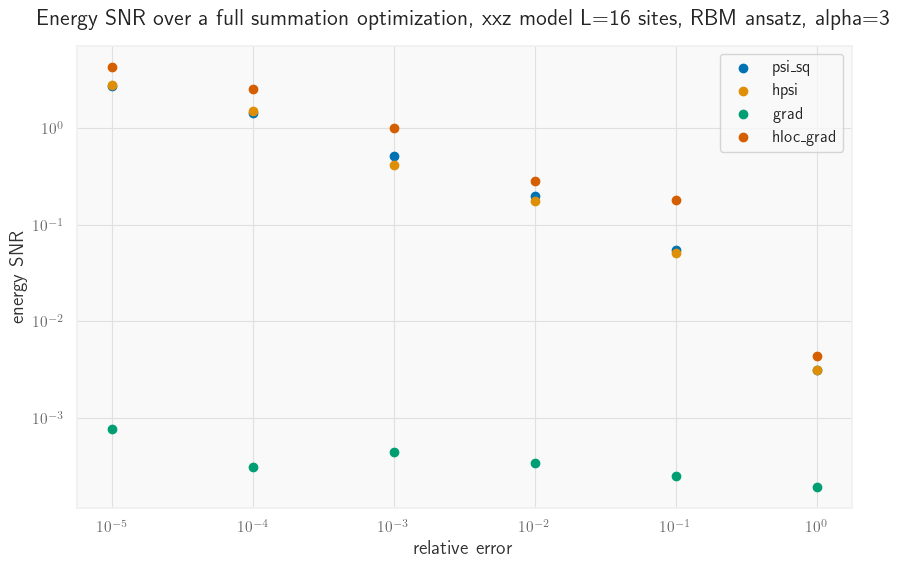

In [38]:
for idx, (key, vals) in enumerate(snr_h_dict.items()):
    if len(vals) >0:
        plt.scatter([10**(-i) for i in range(len(vals))], vals, label=key)
plt.legend()
plt.xlabel("relative error")
plt.ylabel("energy SNR")
plt.xscale("log")
plt.yscale("log")
plt.title(f"Energy SNR over a full summation optimization, {analysis.model.name} model L={analysis.model.Ns} sites, {analysis.ansatz_name} ansatz, alpha={analysis.alpha}")

Text(0.5, 1.0, 'Gradient SNR over a full summation optimization, xxz model L=16 sites, RBM ansatz, alpha=3')

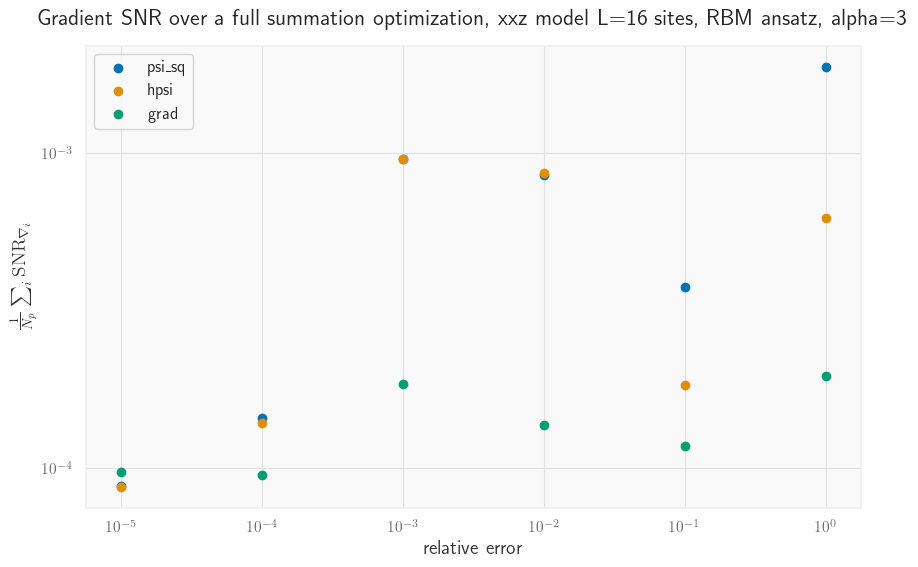

In [32]:
for idx, (key, vals) in enumerate(snr_grad_dict.items()):
    if len(vals) >0:
        plt.scatter([10**(-i) for i in range(len(vals))], vals, label=key)
plt.legend()
plt.xlabel("relative error")
plt.ylabel(r"$\frac{1}{N_p} \sum_i \mathrm{SNR}_{\nabla_i}$")
plt.xscale("log")
plt.yscale("log")
plt.title(f"Gradient SNR over a full summation optimization, {analysis.model.name} model L={analysis.model.Ns} sites, {analysis.ansatz_name} ansatz, alpha={analysis.alpha}")

In [31]:
# plot gradient overlap for several samplers, fixed number of samples (Hpsi, psi^2, psi, H_loc*psi^2, grad, grad*psi^2)
analysis.set_strategy()

num_samples = 10**5

sampler = nk.sampler.ExactSampler(hilbert = analysis.model.hi)
analysis.chunk_size = 8
out_curved_dist = {}
for state_idx in analysis.eval_s:
    print(state_idx)
    # todo : add delta dependency
    analysis.load_state(state_idx)
    S_fs = analysis.S_fs
    F_fs = analysis.force_fs
    exact_dp = analysis.exact_dp #save exact dp and S matrix for parameter space distance
    state_exact = analysis.compute_updated_state(exact_dp)
    exact_dist = fs_dist(analysis.im_t_ev, state_exact)
    analysis.model.H_jax._setup()
    pars = {"params": analysis.vstate.parameters}
    samples_psi_sq = sampler.sample(analysis.vstate._apply_fun, pars, chain_length=num_samples)[0][0]
    
    hloc = compute_eloc(analysis.vstate._apply_fun, pars, analysis.model.H_jax, samples_psi_sq)
    hloc_c = (1/jnp.sqrt(num_samples))*(hloc - jnp.mean(hloc))
    # centered jacobian
    jacobian = nkjax.jacobian(
        analysis.vstate._apply_fun,
        analysis.vstate.parameters,
        samples_psi_sq, #in MC state, this is vstate.samples
        analysis.vstate.model_state,
        mode="holomorphic",
        dense=True,
        center=True,
        chunk_size=analysis.chunk_size//2,
        _sqrt_rescale=True, #(not) rescaled by sqrt[π(x)], but in MC this rescales by 1/sqrt[N_mc]
    )
    jac_mean = jnp.mean(jacobian, axis=0)
    # hloc_grad_psi_delta_func = lambda pars, sigma: hloc_grad_psi_delta(analysis.vstate._apply_fun, analysis.model.H_jax, jnp.mean(hloc), jac_mean, pars, sigma)
    # samples_delta = sampler.sample(hloc_grad_psi_delta_func, pars, chain_length=num_samples)[0][0]

    S_psi_sq = jacobian.conj().T @ jacobian + analysis.diag_shift*jnp.eye(jacobian.shape[1])
    force_psi_sq = jacobian.conj().T @ hloc_c
    force_unrolled = jacobian.conj().T * hloc_c
    std_force = jnp.std(force_unrolled,axis=1)

    dp_psi_sq = analysis.solver_fn(S_psi_sq,  force_psi_sq)[0]
    state_psi_sq = analysis.compute_updated_state(dp_psi_sq)
    print("psi_sq")
    print(jnp.mean(std_force))
    print(curved_dist(force_psi_sq,F_fs, jnp.eye(F_fs.shape[0])))
    print(jnp.linalg.norm(force_psi_sq-F_fs)/jnp.linalg.norm(F_fs))
    print(jnp.linalg.norm(S_psi_sq-S_fs)/jnp.linalg.norm(S_fs))
    print(curved_dist(dp_psi_sq, exact_dp, S_fs))

    # hpsi
    F, S, dp_is, std_f, state_dist = is_test(analysis, Hpsi, pars, num_samples)
    print("hpsi")
    print(std_f)
    print(curved_dist(F,F_fs, jnp.eye(F.shape[0])))
    print(jnp.linalg.norm(F-F_fs)/jnp.linalg.norm(F_fs))
    print(jnp.linalg.norm(S-S_fs)/jnp.linalg.norm(S_fs))
    print(curved_dist(dp_is, exact_dp, S_fs))

    # grad
    F, S, dp_is, std_f, state_dist = is_test(analysis, grad_psi, pars, num_samples)
    print("grad")
    print(std_f)
    print(curved_dist(F,F_fs, jnp.eye(F.shape[0])))
    print(jnp.linalg.norm(F-F_fs)/jnp.linalg.norm(F_fs))
    print(jnp.linalg.norm(S-S_fs)/jnp.linalg.norm(S_fs))
    print(curved_dist(dp_is, exact_dp, S_fs))

    # hloc_grad
    F, S, dp_is, std_f, state_dist = is_test(analysis, hloc_grad_psi, pars, num_samples)
    print('hloc_grad')
    print(std_f)
    print(curved_dist(F,F_fs, jnp.eye(F.shape[0])))
    print(jnp.linalg.norm(F-F_fs)/jnp.linalg.norm(F_fs))
    print(jnp.linalg.norm(S-S_fs)/jnp.linalg.norm(S_fs))
    print(curved_dist(dp_is, exact_dp, S_fs))

    # delta grad
    delta_grad_f = lambda apply_fun, H, params, sigma: grad_psi_delta(apply_fun, H, params, sigma, jac_mean)
    F, S, dp_is, std_f, state_dist = is_test(analysis, delta_grad_f, pars, num_samples)
    print('delta_grad')
    print(std_f)
    print(curved_dist(F,F_fs, jnp.eye(F.shape[0])))
    print(jnp.linalg.norm(F-F_fs)/jnp.linalg.norm(F_fs))
    print(jnp.linalg.norm(S-S_fs)/jnp.linalg.norm(S_fs))
    print(curved_dist(dp_is, exact_dp, S_fs))

    # delta hloc grad
    delta_hloc_grad_f = lambda apply_fun, H, params, sigma: grad_psi_delta(apply_fun, H, params, sigma, jnp.mean(hloc), jac_mean)
    F, S, dp_is, std_f, state_dist = is_test(analysis, delta_grad_f, pars, num_samples)
    print('delta_hloc_grad')
    print(std_f)
    print(curved_dist(F,F_fs, jnp.eye(F.shape[0])))
    print(jnp.linalg.norm(F-F_fs)/jnp.linalg.norm(F_fs))
    print(jnp.linalg.norm(S-S_fs)/jnp.linalg.norm(S_fs))
    print(curved_dist(dp_is, exact_dp, S_fs))


2


2024-12-12 15:24:42.001192: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.22GiB (rounded to 1305600000)requested by op 
2024-12-12 15:24:42.001596: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] *****_**************************_______********____________***************************************__
E1212 15:24:42.001631 2133150 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1305600000 bytes.


KeyboardInterrupt: 

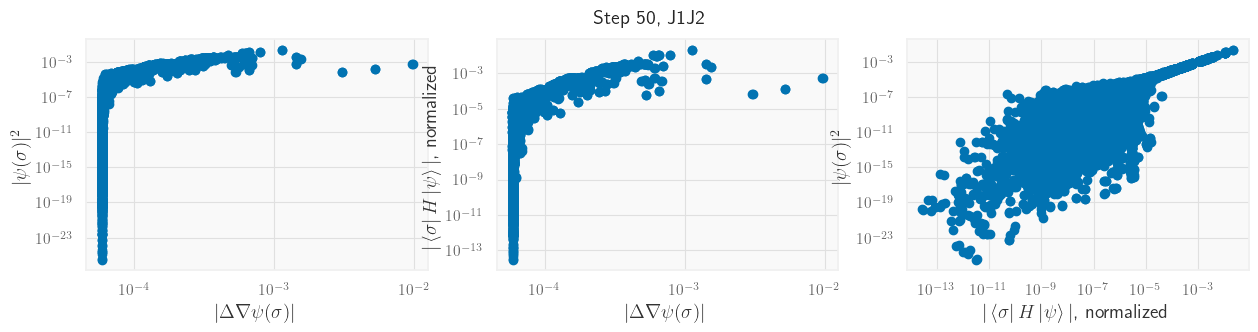

In [ ]:
# plot evolution of centered gradients
cmap = plt.cm.viridis
steps = [50]
fig, axes = plt.subplots(1,3,figsize=(15,3))
for idx, state_idx in enumerate(steps):
    color = cmap(state_idx/200)
    analysis.load_state(state_idx)
    # S_fs = analysis.S_fs
    # F_fs = analysis.force_fs
    v_arr = analysis.vstate_arr
    jacobian_orig = analysis.jacobian_orig
    jac_c = v_arr[:,None]*jacobian_orig - jnp.sum(v_arr[:,None]*jacobian_orig*analysis.pdf[:,None], axis=0)
    # jac_c = v_arr[:,None]*jacobian_orig
    
    # jac_c = jnp.sqrt(analysis.pdf[:,jnp.newaxis])*jac_c
    h_psi_norm = analysis.model.H_sp @ v_arr
    h_psi_norm = jnp.abs(h_psi_norm)**2/jnp.sum(jnp.abs(h_psi_norm)**2)
    hloc_c = jnp.sqrt(analysis.pdf)*(analysis.Hloc - jnp.sum(analysis.Hloc*analysis.pdf))
    force_unrolled = jac_c.conj().T * hloc_c
    # axes[0].plot(jnp.abs(jnp.sum(force_unrolled,axis=0)), alpha = 1-idx/len(steps),  label ="step %d"%state_idx)
    jac_pdf = jnp.sum(jnp.abs(jac_c),axis=1)/jnp.sum(jnp.abs(jac_c))
    axes[0].scatter(jac_pdf, analysis.pdf)
    axes[0].set_ylabel(r"$|\psi(\sigma)|^2$")
    axes[0].set_xlabel(r"$|\Delta \nabla \psi(\sigma) |$")

    # axes[0].scatter(hloc_c.real/jnp.sum(hloc_c.real), analysis.pdf)
    # axes[0].scatter(jnp.abs(jnp.sum(force_unrolled,axis=0)), analysis.pdf)
    # axes[0].plot(jac_pdf, alpha = 1-idx/len(steps),  label ="step %d"%state_idx)
    axes[1].scatter(jac_pdf, h_psi_norm)
    axes[1].set_xlabel(r"$|\Delta \nabla \psi(\sigma) |$")
    axes[1].set_ylabel(r"$|\bra{\sigma} H \ket{\psi}|$, normalized")

    axes[2].scatter(h_psi_norm, analysis.pdf)
    axes[2].set_ylabel(r"$|\psi(\sigma)|^2$")
    axes[2].set_xlabel(r"$|\bra{\sigma} H \ket{\psi}|$, normalized")
fig.suptitle("Step %d, J1J2"%steps[0])
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[2].set_xscale("log")
axes[2].set_yscale("log")

In [ ]:
# from deepnets.net.ViT.net import ViT_Vanilla
# from deepnets.net.ViT.body import extract_patches2d



NameError: name 'deepnets' is not defined

: 

Energy estimation with several IS distributions

In [ ]:
# plot gradient overlap for several samplers, fixed number of samples (Hpsi, psi^2, psi, H_loc*psi^2, grad, grad*psi^2)
analysis.set_strategy()
from tqdm import tqdm
import jax.numpy as jnp
import jax
from grad_sample.utils.misc import compute_eloc
from grad_sample.utils.distances import curved_dist, fs_dist, param_overlap
fs_dist_pdf = []
num_trials = 3 # each error thresh, sample and estimate 10 times
num_samples = 10**4
res_overlap = []
sampler = nk.sampler.ExactSampler(hilbert= analysis.model.hi)
analysis.chunk_size = 8
for state_idx in tqdm(analysis.eval_s):
    # todo : add delta dependency
    analysis.load_state(state_idx)
    S_fs = analysis.S_fs
    exact_dp = analysis.exact_dp #save exact dp and S matrix for parameter space distance
    e_fs = jnp.sum(analysis.pdf*analysis.Hloc).real
    print("true energy")
    print(e_fs)
    state_exact = analysis.compute_updated_state(exact_dp)
   
    exact_dist = fs_dist(analysis.im_t_ev, state_exact)
    analysis.model.H_jax._setup()
    # sampler burnin for reduced errors
    Hpsi_func = lambda pars, sigma: Hpsi(analysis.vstate._apply_fun, analysis.model.H_jax, pars, sigma)
    Hloc_psi_func = lambda pars, sigma: Hlocpsi(analysis.vstate._apply_fun, analysis.model.H_jax, pars, sigma)
    grad_func = lambda pars, sigma: grad(analysis.vstate._apply_fun, pars, sigma)
    grad_psi_func = lambda pars, sigma: grad_psi(analysis.vstate._apply_fun, pars, sigma)
    

    samples_psi_sq = sampler.sample(analysis.vstate._apply_fun, {"params": analysis.vstate.parameters}, chain_length=num_samples)[0][0]
    samples_Hpsi = sampler.sample(Hpsi_func, {"params": analysis.vstate.parameters}, chain_length=num_samples)[0][0]
    samples_Hloc_psi = sampler.sample(Hloc_psi_func, {"params": analysis.vstate.parameters}, chain_length=num_samples)[0][0]
    # samples_grad = sampler.sample(grad_func, {"params": analysis.vstate.parameters}, chain_length=num_samples)[0][0]
    # samples_grad = sampler.sample(grad_psi_func, {"params": analysis.vstate.parameters}, chain_length=num_samples)[0][0]
    
    # compute approx dp
    # Hloc = analysis.model.H_sp @ analysis.vstate_arr / analysis.vstate_arr

    # Energy estimation
    Hloc = compute_eloc(analysis.vstate._apply_fun, {"params": analysis.vstate.parameters}, analysis.model.H_jax, samples_psi_sq)
    print("mean energy psi_sq %.2f"%jnp.mean(Hloc.real))
    print(jnp.abs(jnp.mean(Hloc.real) - e_fs)/jnp.abs(e_fs))
    print("std psi_sq %.4f"%(1/jnp.sqrt(num_samples)*jnp.std(Hloc.real)))
    Hloc_c = (1/jnp.sqrt(num_samples))*(Hloc - jnp.mean(Hloc))

    Hloc_Hpsi, norm_const = IS_estimator_hloc(Hpsi_func, analysis.vstate._apply_fun, analysis.model.H_jax, {"params": analysis.vstate.parameters}, samples_Hpsi)
    hloc_estim, std_estim = estimate_mean_std_IS(Hloc_Hpsi, norm_const)
    print("mean energy Hpsi %.2f"%(hloc_estim))
    print(jnp.abs(hloc_estim - e_fs)/jnp.abs(e_fs))
    print("std Hpsi %.4f"%(std_estim))

    Hloc_Hloc, norm_const_hloc = IS_estimator_hloc(Hloc_psi_func, analysis.vstate._apply_fun, analysis.model.H_jax, {"params": analysis.vstate.parameters}, samples_Hloc_psi)
    hloc_estim, std_estim = estimate_mean_std_IS(Hloc_Hloc, norm_const_hloc)
    print("mean energy Hloc %.2f"%(hloc_estim))
    print(jnp.abs(hloc_estim - e_fs)/jnp.abs(e_fs))
    print("std Hloc %.4f"%(std_estim))

  0%|          | 0/5 [00:00<?, ?it/s]

true energy
3.1960855631579825


  0%|          | 0/5 [00:01<?, ?it/s]


KeyboardInterrupt: 

: 

: 

: 